# Decision Tree
## _Modelo: Decision Tree Regressor_

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score, root_mean_squared_error
import seaborn as sns
import pickle

## Preparación

In [2]:
df_scaled = pd.read_csv('df_scaled.csv')

In [3]:
# Dividimos nuestros datos para entrenamiento y test
X = df_scaled.drop(columns=['track_id', 'track_popularity'])
y = df_scaled['track_popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Análisis de profundidad y alpha

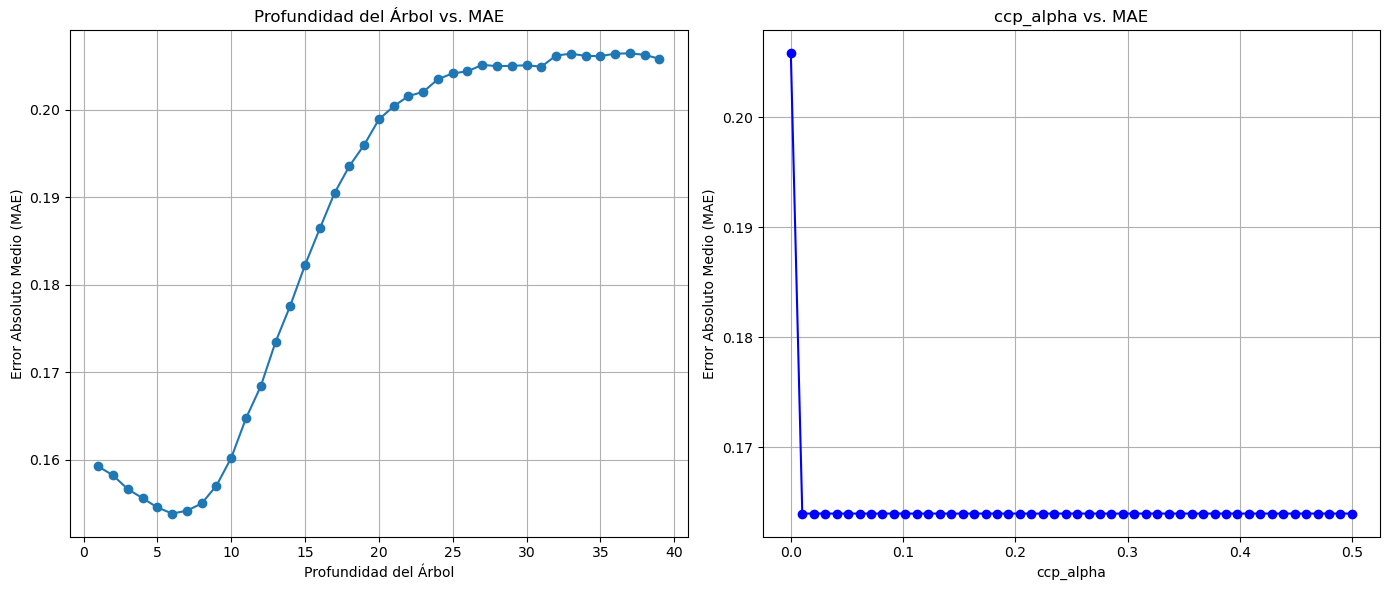

In [4]:
# Vemos como la profundidad y el valor de alpha afectan el MAE

depths = range(1, 40)
mae_scores_depth = []

for depth in depths:
    dt_regressor = DecisionTreeRegressor(max_depth=depth, random_state=42)
    scores = cross_val_score(dt_regressor, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    mae_scores_depth.append(-scores.mean())

ccp_alphas = np.linspace(0, 0.5, 50)

mae_scores_alpha = []

for ccp_alpha in ccp_alphas:
    dt_regressor_alpha = DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alpha)
    scores_alpha = cross_val_score(dt_regressor_alpha, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    mae_scores_alpha.append(-scores_alpha.mean())

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(depths, mae_scores_depth, marker='o')
plt.title('Profundidad del Árbol vs. MAE')
plt.xlabel('Profundidad del Árbol')
plt.ylabel('Error Absoluto Medio (MAE)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(ccp_alphas, mae_scores_alpha, marker='o', color='b')
plt.title('ccp_alpha vs. MAE')
plt.xlabel('ccp_alpha')
plt.ylabel('Error Absoluto Medio (MAE)')
plt.grid(True)

plt.tight_layout()
plt.show()

Vemos que el MAE no cambia ante valores de alpha mayores a 0

#### Entrenamos un árbol sin podar y evaluamos el rendimiento.

In [5]:
# Creamos el primer árbol sin podar
dt = DecisionTreeRegressor(criterion='squared_error', splitter='best',
                                   max_depth=None, min_samples_split=2, min_samples_leaf=1,
                                   random_state=42)

dt.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [6]:
# Vemos el tamaño del árbol (número de nodos y profundidad)
tree_depth = dt.get_depth()
tree_n_leaves = dt.get_n_leaves()

print(f"Profundidad del árbol: {tree_depth}")
print(f"Número de hojas: {tree_n_leaves}")

Profundidad del árbol: 36
Número de hojas: 14655


In [7]:
# Entrenamos y evaluamos el modelo
y_pred = dt.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"R2: {r2}")

MAE: 0.20032774915831747
MSE: 0.06516191251423695
RMSE: 0.25526831474790784
MAPE: 11150761418680.186
R2: -0.6768840937600515


## Entrenamiento

#### Realizamos una búsqueda del mejor valor de ccp_alpha usando GridSearchCV

In [8]:
dt_regressor = DecisionTreeRegressor(criterion='squared_error', splitter='best', 
                                   max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                                   random_state=42)

# Definimos el rango de valores para ccp_alpha
param_grid = {
    'ccp_alpha': np.linspace(0, 0.5, 500)
}

# Configuramos GridSearchCV con validación cruzada (cv=5)
grid_search = GridSearchCV(dt_regressor, param_grid, scoring='neg_mean_squared_error', cv=5)

In [9]:
# Entrenamos con el conjunto de entrenamiento
grid_search.fit(X_train, y_train)

# Obtenemos el mejor valor de ccp_alpha y el mejor modelo entrenado
best_alpha = grid_search.best_params_['ccp_alpha']
best_model = grid_search.best_estimator_

print(f"Mejor valor de ccp_alpha: {best_alpha:.4f}")

Mejor valor de ccp_alpha: 0.0010


In [10]:
# Exportación del modelo
if best_model is not None:
    model_save_path = 'models/decisionTreeRegressor.pkl'
    with open(model_save_path, 'wb') as f:
        pickle.dump(best_model, f)
    print(f"Mejor modelo: {best_model}")
    print(f"Guardado como '{model_save_path}'")

Mejor modelo: DecisionTreeRegressor(ccp_alpha=np.float64(0.001002004008016032),
                      random_state=42)
Guardado como 'models/decisionTreeRegressor.pkl'


## Estudio de métricas

In [11]:
# Vemos el tamaño del árbol (número de nodos y profundidad)
tree_depth = best_model.get_depth()
tree_n_leaves = best_model.get_n_leaves()

print(f"Profundidad del árbol: {tree_depth}")
print(f"Número de hojas: {tree_n_leaves}")

Profundidad del árbol: 1
Número de hojas: 2


In [16]:
features = ['danceability', 'energy', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'year', 'genre_edm', 'genre_latin',
       'genre_pop', 'genre_r&b', 'genre_rap', 'genre_rock']

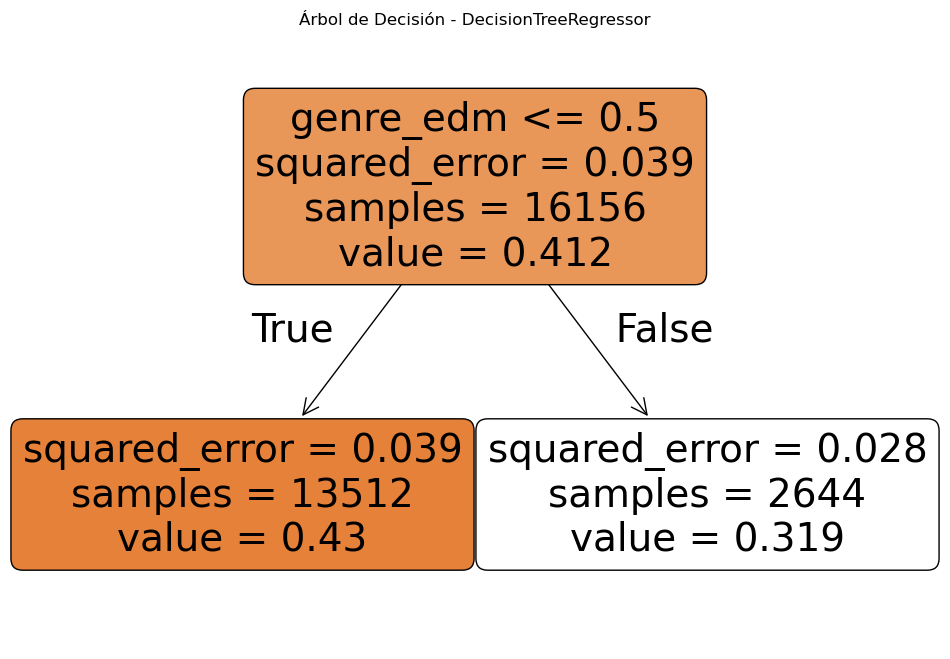

In [17]:
#Gráficamos el árbol
plt.close('all')
plt.figure(figsize=(12, 8))
plot_tree(best_model, filled=True, feature_names=features, rounded=True)
plt.title("Árbol de Decisión - DecisionTreeRegressor")
plt.show()

#### Entrenamos y evaluamos el mejor modelo

In [13]:
# Entrenamos y evaluamos el mejor modelo
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"R2: {r2}")

MAE: 0.15827403689508782
MSE: 0.036805498220418564
RMSE: 0.1918475911248785
MAPE: 10817508162081.604
R2: 0.05284310807714332


#### Conclusión

| Alpha      | Profundidad del árbol | Número de hojas | MAE             | MSE              | RMSE            | MAPE             | R2                  |
|------------|-----------------------|-----------------|-----------------|------------------|-----------------|------------------|---------------------|
| 0.0        | 36                    | 14,655          | 0.2003          | 0.0652           | 0.2553          | 11,150,761,418,680.19 | -0.6769            |
| 0.0010     | 1                     | 2               | 0.1583          | 0.0368           | 0.1918          | 10,817,508,162,081.60 | 0.0528             |


Del análisis inicial podemos concluir que la poda no afecta demasiado el rendimiento del modelo. De todas formas, se buscó y evaluó el mejor alpha. 
Luego de la evaluación vemos que las métricas en general mejoraron muy ligeramente en relación al árbol inicial, pero es importante destacar que se redujo considerablemente el árbol.